<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

# **License Plate Recognition with OpenCV and OCR**
Welcome to the implementation of a license plate recognition program

This colab: [Link](https://colab.research.google.com/drive/1XRpyAUkMv7zDJI4YXEjpgIazhfON3bfa?usp=sharing)
Dataset: [Link](https://www.kaggle.com/andrewmvd/car-plate-detection)

---




## Importing Necessary Libraries


*   Numpy: Python library for mathematical functions
*   Matplotlib: Python library for creating visualizations
*   EasyOCR (Easy Optical Character Recognition): a GPU-enabled deep learning library capable of recognizing text in 58 different languages.
*   OpenCV (Open Computer Vision): a popular Python library used for image and video analysis
*   Pytesseract: Language Recognition Library






In [ ]:
# Import necessary libraries
import cv2
from matplotlib import pyplot as plt
import numpy as np

## Image Processing

* imread(): Reading an image
  * Arguments: 1) String containing name of image file
* cvtColor(): Changing color spaces
  * Arguments: 1) Image  2) Color space you want to change it to
* imshow(): Show image
  * Arguments: 1) Image. In this case, we are converting to the RGB color space from BGR color space before showing the image
*Note: BGR Color Space is an additive color model where the different intensities of Blue, Green and Red give different shades of color. In this case, converting the image from BGR to RGB eliminates any color mixing.

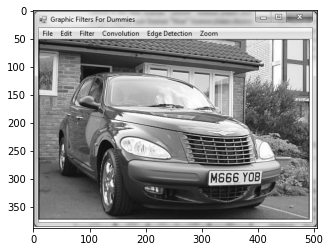

In [ ]:
# Read image
img = cv2.imread('Cars18.png')

# show image
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show image
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

* bilateralFilter()- noise reduction filter which works by taking the average of the pixels around it while preserving the edges
  * Arguments- 1) input image, 2) diameter of pixel neighborhood, 3) sigma value to control color space of pixel neighborhood (higher value = relatively different colors will mix together), 4) Sigma Space
* Note: Parameters needed to be trial and error by audience (not set)

* Canny()- detects and plots the presence of edges
  * Arguments- 1) input image, 2) first threshold, 3) second threshold
  * Hysteresis thresholding: any edge found must have a gradient value greater than the first threshold and connected to an edge with a gradient value greater than the second threshold.




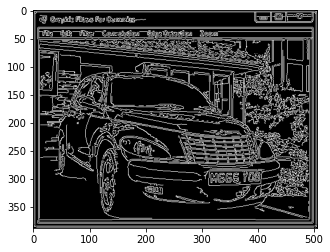

In [ ]:
# Noise Reduction Filter
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

# Canny Edge Detection Filter
edged = cv2.Canny(bfilter, 30, 200)

# Show image
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))


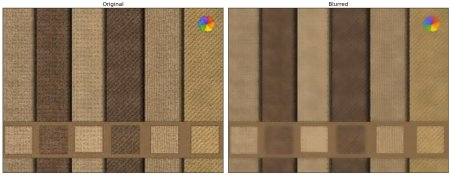
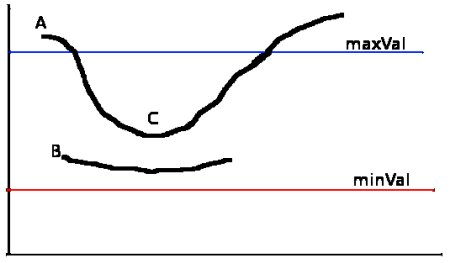

## Image Segmentation

* findCountours(): a curve joining points that have similar color or intensity. Finds white objects from a black background.
  * Arguments- 1) image, 2) Retrieval mode, 3) Approximation Method
  * Retrieval mode: how do you want the contours to be returned? In this case, RETR_TREE retrieves all of the contours and reconstructs a full hierarchy of nested contours.
  * Approximation method: how should it deal with contours that it finds? In this case, CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points. This is exactly what we are looking for since the license plate is rectangular, and can be defined as 4 coordinate points on a grid.

* sorted(): orders the contours by area from largest to smallest and picks out the first 10 (aka the largest 10 contours)
  * Arguments- 1) contours 2) metric for sorting 3) Descending? 


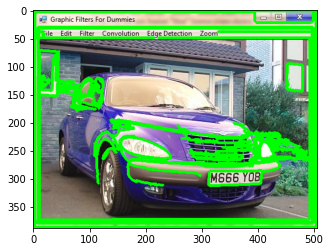

In [ ]:
# Search for clearly defined shapes
contours, heirarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Grabs right tuple values based on OpenCV version
# Saves 10 largest contours
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

# Show contours (optional)
contours_img = img.copy()
cv2.drawContours(contours_img, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img)




*   approxPolyDP: a method that uses the  Ramer‑Douglas‑Peucker Algorithm on a contour to create a more accurate quadrilateral
Params:
  * contour: the contour on which the algorithm is to be applied
  * epsilon: number the determines how free or strict the algorithm will be
  * closed: boolean that determines whether to use apgorithm only on closed contours


In [ ]:
# Iterate through contours
location = None 

for contour in contours:
# find a closed contour with epsilon
  approx = cv2.approxPolyDP(contour, 3, True)

  if len(approx) == 4:
    location = approx
    break

# print out location
print(location)

[[[407 287]]

 [[402 309]]

 [[312 310]]

 [[315 286]]]


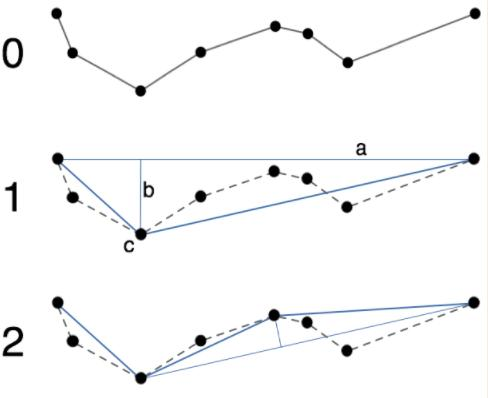

* np.zeros(): blank canvas. 
  * Arguments: 1) dimensions of this image 2) what we want to fill in it. 
  * In this case we just want to fill it with 0s as integers.
* drawContours()- draws contours onto the image. 
  * Arguments: 1) image 2) location passed as a Python list 3) the index of the contour we want to draw (in this case there is only one contour, so we use index 0) 4) then the color of the contour when it outlines the license plate 5) the thickness of the contour, which in this case we want to include the whole contour, so we put -1.
* bitwise_and() to tell the blank image to compare the blank contoured image and the original image and include only the part which is contoured. 
  * Arguments: 1) source image 2) source image 3) what to include


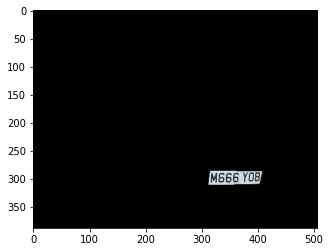

In [ ]:
# Crop the image to the contour found in previous step
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask = mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))


* np.where(): isolate the places where there is white in the image
  * Arguments: 1) mask==255 as the argument which means that x and y should only include coordinates in which the pixels are white.

* (x1, y1): starting coordinates for the license plate. The x-coordinate of the starting of the license plate will be the smallest coordinate in the list of x-coordinates we found in the previous line. And similarly, the starting y-coordinate of the license plate will be the smallest coordinate in the list of y-coordinates from the previous line.

* Do the same thing with the max x and y coordinates to find the right hand side of the license plate

* Now we can create a new image based on these coordinates. 


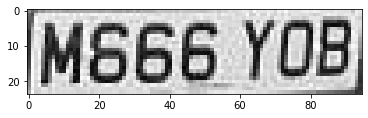

In [ ]:
# Isolate the image to where there is actual data
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))

# Create a new image with just the license plate
cropped_image = gray[x1 : x2, y1 : y2]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))


## Character Recognition

### [EasyOCR](https://github.com/JaidedAI/EasyOCR)

In [ ]:
!pip install easyocr

Reader method:
This method loads a model that is used to determine the chracters on the image.
The parameter is the list of languages that are applied

In [ ]:
# Implement EasyOCR
import easyocr

# Load the model and also set the language
reader = easyocr.Reader(['en'])

# Pass in the image to the model
result = reader.readtext(cropped_image)
print(result)

[([[0, 0], [95, 0], [95, 24], [0, 24]], 'Ms66 YOB', 0.7143649316988392)]


In [ ]:
# Pick out the license plate characters
text = result[0][-2]
print(text)


Ms66 YOB


### [Tesseract](https://github.com/tesseract-ocr/)

In [ ]:
# Import necessary libraries
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
import regex as re
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


image_to_string: method that takes in an image and determines the characters in it.
  * cropped_img: image to determine characters on.

In [ ]:
# Detecting string from image using tesseract
resultStr = pytesseract.image_to_string(cropped_image)
print(resultStr)

In [ ]:
# Clean the string to show only alphanumeric characters
letterAndNums = re.findall("[A-Za-z0-9]+", text)
print("".join(letterAndNums))



Ms66YOB


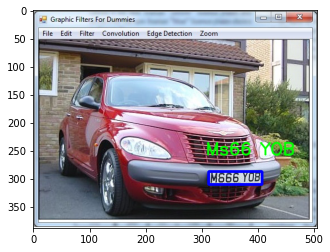

In [ ]:
# Draw the predicted plate onto the image
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text = text, org=(approx[0][0][0] - 100, approx[0][0][1] - 30), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (255,0,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))


FEEDBACK FORM: https://forms.gle/KqGZMYLi5ZJC4aBt6